In [2]:
# 1. Download the datasets - Boston House pricing, Titanic survivors

# Choose datasets that have less 50K instances and 20 features, to keep training times reasonable
# Choose a multivariate classification dataset
# Avoid datasets with missing  data. Do not need imputation
# Avoid imbalanced dataset to keep the metric to accuracy or f1


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations, product

import matplotlib.pyplot as plt 

from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate

from ucimlrepo import fetch_ucirepo 

# from utils import plot_decision_tree, plot_decision_surface, plot_feature_importance, plot_partial_dependence
from utils import get_data, get_df_details, plot_distrb

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [5]:
X.shape

(13611, 16)

In [6]:
X_summary = get_df_details(X)
X_summary.merge(variables.set_index('name'), how='outer', left_index=True, right_index=True)

count          mean           std           min  \
Area             13611.0  53048.284549  29324.095717  20420.000000   
AspectRatio      13611.0      1.583242      0.246678      1.024868   
Class                NaN           NaN           NaN           NaN   
Compactness      13611.0      0.799864      0.061713      0.640577   
ConvexArea       13611.0  53768.200206  29774.915817  20684.000000   
Eccentricity     13611.0      0.750895      0.092002      0.218951   
EquivDiameter    13611.0    253.064220     59.177120    161.243764   
Extent           13611.0      0.749733      0.049086      0.555315   
MajorAxisLength  13611.0    320.141867     85.694186    183.601165   
MinorAxisLength  13611.0    202.270714     44.970091    122.512653   
Perimeter        13611.0    855.283459    214.289696    524.736000   
Roundness        13611.0      0.873282      0.059520      0.489618   
ShapeFactor1     13611.0      0.006564      0.001128      0.002778   
ShapeFactor2     13611.0      0.001716      0.000596      0.000564   
ShapeFactor3     13611.0      0.643590      0.098996      0.410339   
ShapeFactor4     13611.0      0.995063      0.004366      0.947687   
Solidity         13611.0      0.987143      0.004660      0.919246   

                          25%           50%           75%            max  \
Area             36328.000000  44652.000000  61332.000000  254616.000000   
AspectRatio          1.432307      1.551124      1.707109       2.430306   
Class                     NaN           NaN           NaN            NaN   
Compactness          0.762469      0.801277      0.834270       0.987303   
ConvexArea       36714.500000  45178.000000  62294.000000  263261.000000   
Eccentricity         0.715928      0.764441      0.810466       0.911423   
EquivDiameter      215.068003    238.438026    279.446467     569.374358   
Extent               0.718634      0.759859      0.786851       0.866195   
MajorAxisLength    253.303633    296.883367    376.495012     738.860154   
MinorAxisLength    175.848170    192.431733    217.031741     460.198497   
Perimeter          703.523500    794.941000    977.213000    1985.370000   
Roundness            0.832096      0.883157      0.916869       0.990685   
ShapeFactor1         0.005900      0.006645      0.007271       0.010451   
ShapeFactor2         0.001154      0.001694      0.002170       0.003665   
ShapeFactor3         0.581359      0.642044      0.696006       0.974767   
ShapeFactor4         0.993703      0.996386      0.997883       0.999733   
Solidity             0.985670      0.988283      0.990013       0.994677   

                 nunique  n_nulls    dtype     role         type demographic  \
Area             12011.0      0.0    int64  Feature      Integer        None   
AspectRatio      13543.0      0.0  float64  Feature   Continuous        None   
Class                NaN      NaN      NaN   Target  Categorical        None   
Compactness      13543.0      0.0  float64  Feature   Continuous        None   
ConvexArea       12066.0      0.0    int64  Feature      Integer        None   
Eccentricity     13543.0      0.0  float64  Feature   Continuous        None   
EquivDiameter    12011.0      0.0  float64  Feature   Continuous        None   
Extent           13535.0      0.0  float64  Feature   Continuous        None   
MajorAxisLength  13543.0      0.0  float64  Feature   Continuous        None   
MinorAxisLength  13543.0      0.0  float64  Feature   Continuous        None   
Perimeter        13351.0      0.0  float64  Feature   Continuous        None   
Roundness        13540.0      0.0  float64  Feature   Continuous        None   
ShapeFactor1     13521.0      0.0  float64  Feature   Continuous        None   
ShapeFactor2     13506.0      0.0  float64  Feature   Continuous        None   
ShapeFactor3     13543.0      0.0  float64  Feature   Continuous        None   
ShapeFactor4     13532.0      0.0  float64  Feature   Continuous        None   
Solidity         13522.0     

In [7]:
idx = variables['type'].isin(['Integer', 'Continuous'])
int_cols = variables.loc[idx, 'name']
int_cols = int_cols.loc[~int_cols.isin(y.columns.tolist())]

In [8]:
int_cols

0                Area
1           Perimeter
2     MajorAxisLength
3     MinorAxisLength
4         AspectRatio
5        Eccentricity
6          ConvexArea
7       EquivDiameter
8              Extent
9            Solidity
10          Roundness
11        Compactness
12       ShapeFactor1
13       ShapeFactor2
14       ShapeFactor3
15       ShapeFactor4
Name: name, dtype: object

In [9]:
idx = variables['type'].isin(['Categorical', 'Binary'])
cat_cols = variables.loc[idx, 'name']

cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]


In [10]:
cat_cols

Series([], Name: name, dtype: object)

In [16]:
y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [11]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)



# EDA - on the TRAIN data set
1. For the binary/Categorical value to a % plot of distribution
2. For the continuous/integer data - do a violin plot distribution
3. Do a correlation plot of the numeric series

In [12]:

X_eda = X_train.copy()

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


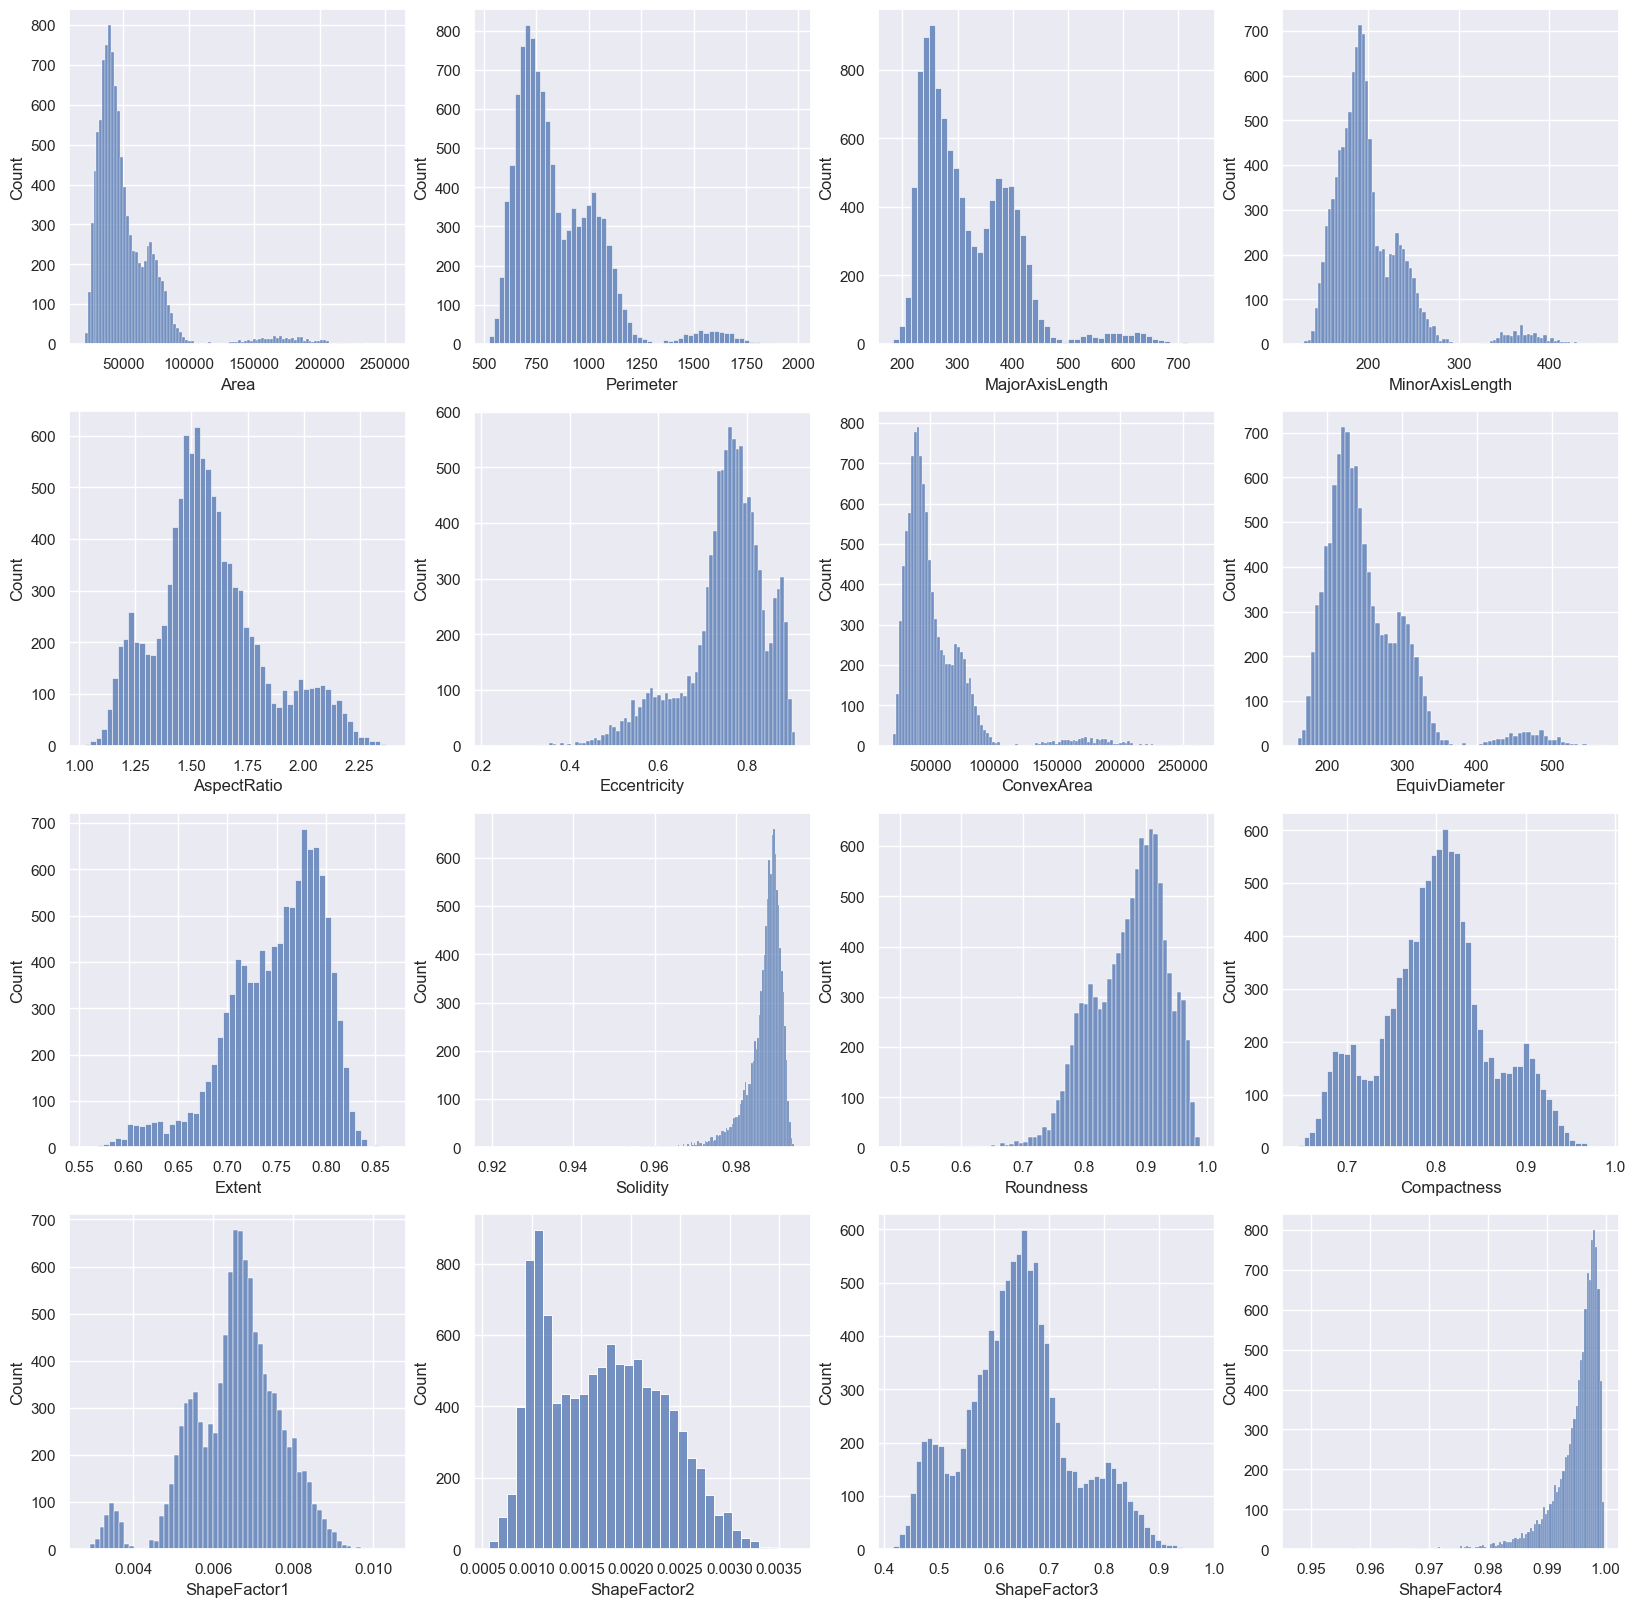

In [13]:
plot_distrb(X_eda)

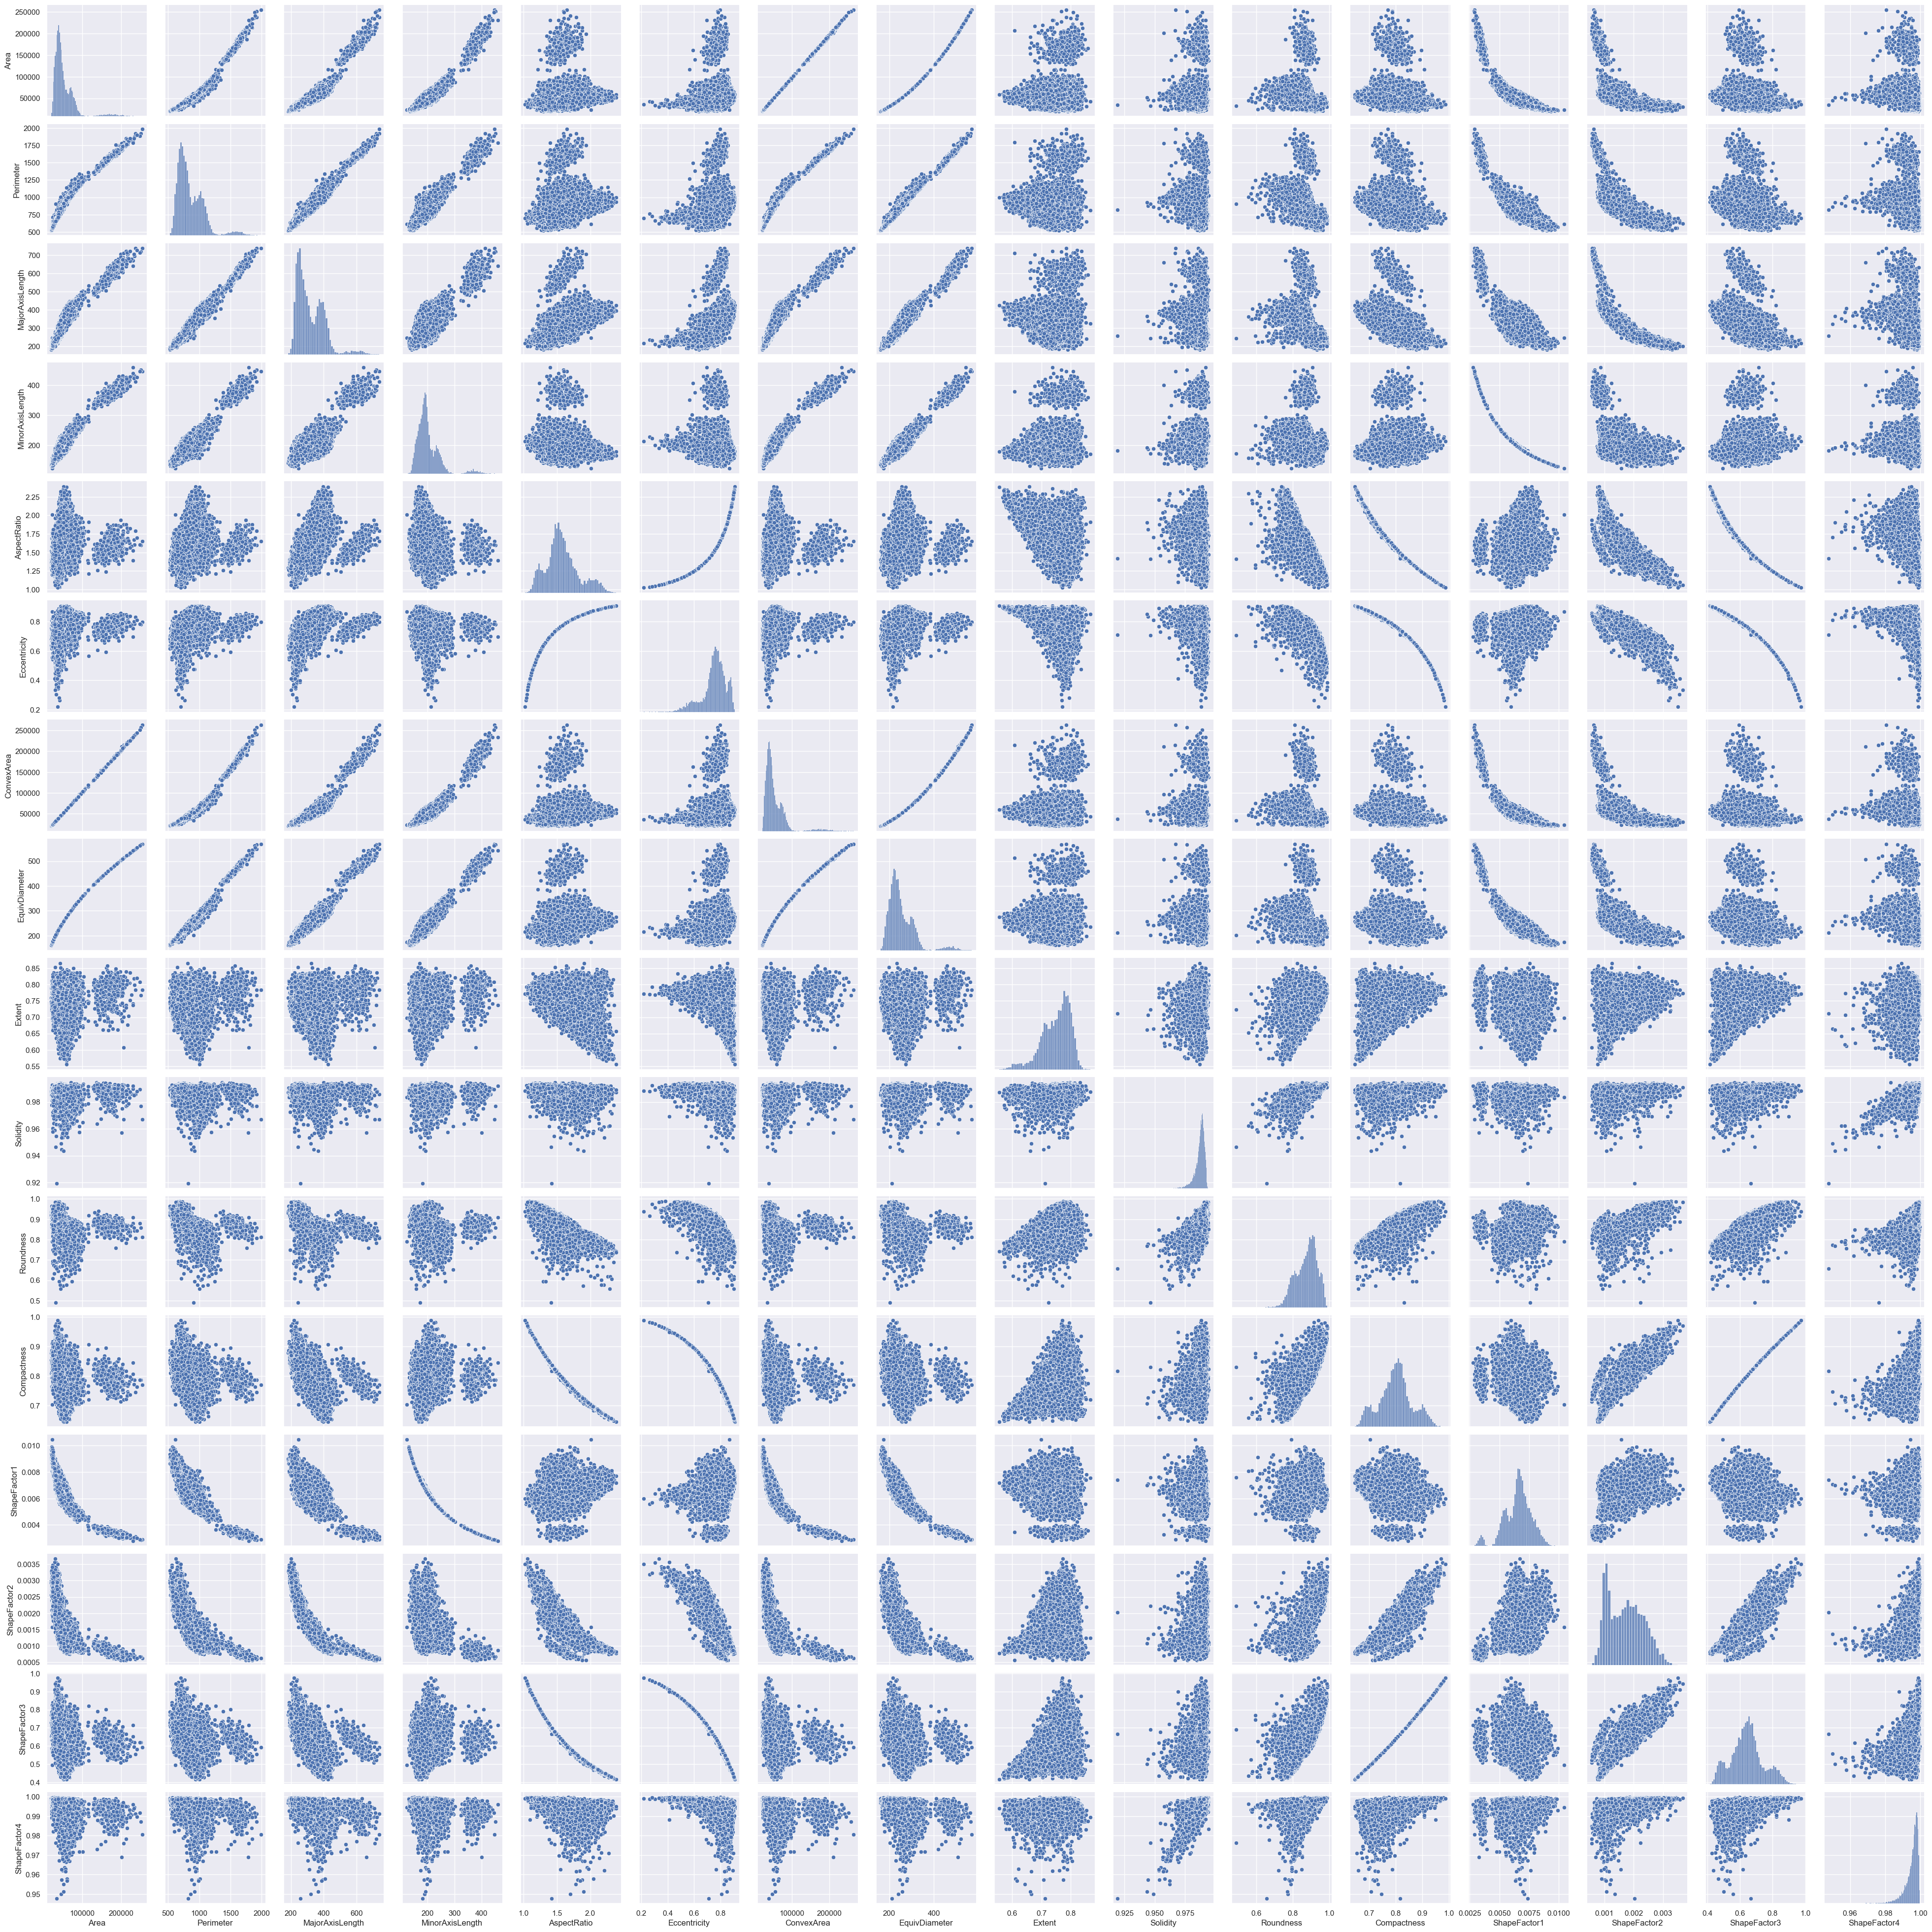

In [15]:
sns.pairplot(X_eda, )

<Axes: >

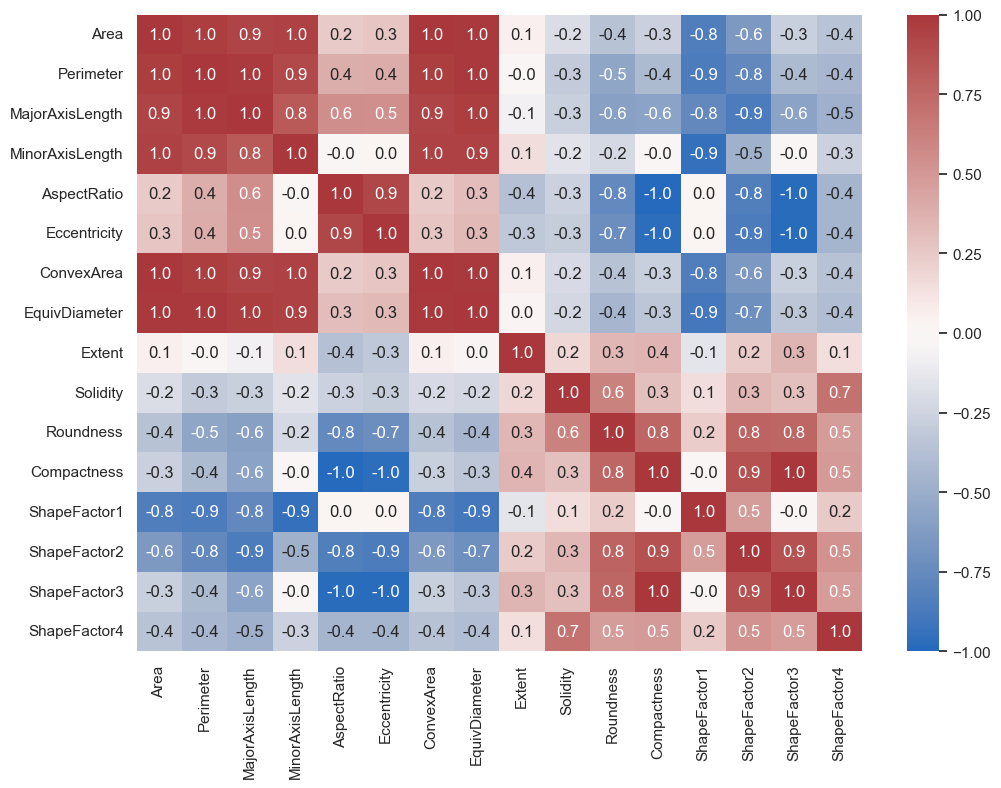

In [14]:
sns.heatmap(X_eda[int_cols].corr(),annot=True, fmt=".1f", vmin=-1, vmax = 1, cmap='vlag')